# Comparison of McBEF vs Classic Biome Dependent Heat Fluxes

This notebook compares the inputs

* McBEF
* Classic Freitas PR model assumptions implemented in plumerise.bioma

Notice that the classic flaming heatfluxes and the fraction of flaming/smoldering fires are prescribed as a function of biome type.

In [1]:
import os
import sys

#import importlib
#importlib.reload(kde)

from IPython.display import display, Markdown

import numpy as np
import xarray as xr
from datetime import datetime, timedelta

from pyobs     import kde
from plumerise import bioma as bm

import matplotlib.pyplot as plt
%matplotlib inline 

lb, mode, ub = (0, 1, 2)  # indices for McBEF stats


## Load data

In [2]:
def getFiresMetOneDay(day,Verbose=False):
    """
    Ingests McBEF retrievals and sampled meteorology for one day.
    """
    
    
    l2_dirn = '/css/viirs/data/Level2/VNP47MCBEF/2019/'
    f_fname = l2_dirn + 'VNP47MCBEF.Stats.A2019%03d.0000_2400.Uniform_v_1_0_0.nc'%day
    
    f = xr.open_dataset(f_fname) # fire property statistics
    
    if Verbose:
        display(Markdown("**FIRE PROPERTIES**"),f)
        
    # Biome Types using FILDA provided vegetation types
    # -------------------------------------------------
    bf = bm.getAggregateBiome ( f.FP_Land_Type, f.FP_Latitude)
                                 
    # Classic (biome-dependent heat fluxes)
    # ------------------------------------
    (cPower_f, cPower_s, cHeatFlux_f, cArea_f) = bm.getHeatFlux ( bf, f.Power[:,mode] ) # using FILDA biome type
                                                                      
    return (f, bf, cPower_f, cPower_s, cHeatFlux_f, cArea_f)
                           
                           

## Compute Mean KDE of Heat FLuxes, Areas, Power

In [3]:
def prop_KDE(b,biome,X,P,N=256,range=None):
    """
    Accumulates KDE of X.
    """
    
    if len(X.shape) == 2:
        P_ = np.zeros((3,N))
        I = (b==biome)&(np.isnan(X[:,1])==False)
        bins, P_[0,:] = kde.calc_kde1d(X[I,0],range=range)
        bins, P_[1,:] = kde.calc_kde1d(X[I,1],range=range)
        bins, P_[2,:] = kde.calc_kde1d(X[I,2],range=range)
    else:
        P_ = np.zeros(N)
        I = (b==biome)&(np.isnan(X)==False)
        bins, P_ = kde.calc_kde1d(X[I],N=N,range=range)
     
    P += P_                
                      
    return (bins,P)
                     

In [4]:
N = 256  # number of KDE bins

# Mean KDE
# --------
fHEATFLUX_F, cHEATFLUX_F = np.zeros((4,3,N)), np.zeros((4,3,N))
fHEATFLUX_S = np.zeros((4,3,N))
fAREA_F,         cAREA_F = np.zeros((4,3,N)), np.zeros((4,3,N))
fPOWER_F,       cPOWER_F = np.zeros((4,3,N)), np.zeros((4,N))
fPOWER_R = np.zeros((4,3,N))

fPOWER, fPOWER_M, fPOWER_1mM = np.zeros((4,N)), np.zeros((4,N)), np.zeros((4,N))

# Loop over days...
ndays = 0
oneday = timedelta(seconds=24*60*60)
date0 = datetime(2018,12,31)
for day in range(182,305):
#for day in range(182,184):

    if day%4 == 0: print('| Day ',date0+day*oneday,end='\r')
    if day%4 == 1: print('/ Day ',date0+day*oneday,end='\r')
    if day%4 == 2: print('_ Day ',date0+day*oneday,end='\r')
    if day%4 == 3: print('\ Day ',date0+day*oneday,end='\r')
              
    ndays += 1
    
    # Load fires and met fields
    # -------------------------
    (f, bf, cPower_f, cPower_s, cHeatFlux_f, cArea_f)  = getFiresMetOneDay(day,Verbose=False)
    
    # Estimate KDE
    # ------------
    for b in range(4):
        
        bins_HF, fHEATFLUX_F[b] = prop_KDE(bf, b+1, 1000*f.HeatFlux_f, fHEATFLUX_F[b], range=(0,300))
        bins_HS, fHEATFLUX_S[b] = prop_KDE(bf, b+1, 1000*f.HeatFlux_s, fHEATFLUX_S[b], range=(0,30))
        
        bins_A, fAREA_F[b] = prop_KDE(bf, b+1, f.Area_f, fAREA_F[b], range=(0,500))
        bins_A, cAREA_F[b] = prop_KDE(bf, b+1,  cArea_f, cAREA_F[b], range=(0,500))

        bins_P, fPOWER_F[b] = prop_KDE(bf, b+1, f.Power_f, fPOWER_F[b], range=(0,20))
        bins_P, cPOWER_F[b] = prop_KDE(bf, b+1,  cPower_f, cPOWER_F[b], range=(0,20))
        
        bins_M, fPOWER[b]     = prop_KDE(bf, b+1, f.Power[:,mode], fPOWER[b], range=(0,40))
        bins_M, fPOWER_M[b]   = prop_KDE(bf, b+1, f.FP_MCE*f.Power[:,mode], fPOWER_M[b], range=(0,40))  
        bins_M, fPOWER_1mM[b] = prop_KDE(bf, b+1, (1-f.FP_MCE)*f.Power[:,mode], fPOWER_1mM[b], range=(0,40))   
        
        bins_R, fPOWER_R[b] = prop_KDE(bf, b+1, f.Power_f/f.Power, fPOWER_R[b], range=(0,1))    
      
# Normalize
# ---------
for P in [ fHEATFLUX_F, 
           fHEATFLUX_S, 
           fAREA_F,  
           cAREA_F,
           fPOWER_F, 
           cPOWER_F, 
           fPOWER_R,
           fPOWER, fPOWER_M, fPOWER_1mM,
         ]:
    P = P / ndays
    
# Save it for later
# -----------------
f_npz = './VNP47MCBEF.HF_KDE.npz'
np.savez(f_npz,
         bins_HF=bins_HF, bins_HS=bins_HS, bins_A=bins_A, bins_P=bins_P,bins_R=bins_R,bins_M=bins_M,
         fHEATFLUX_F=fHEATFLUX_F, 
         fHEATFLUX_S=fHEATFLUX_S, 
         fAREA_F=fAREA_F,  
         cAREA_F=cAREA_F,
         fPOWER_F=fPOWER_F,
         cPOWER_F=cPOWER_F,
         fPOWER_R=fPOWER_R,
         fPOWER=fPOWER,
         fPOWER_M=fPOWER_M, 
         fPOWER_1mM=fPOWER_1mM,
        )
             
    

## Plotting Mean KDEs for each Aggregated Biome
Next we plot the mean KDEs for each biome

In [5]:
f_npz = './VNP47MCBEF.HF_KDE.npz'
f = np.load(f_npz)  # retrieve KDEs from disk
for v_ in f.keys():
    setattr(sys.modules[__name__], v_, f[v_])

### Heat Fluxes and Flaming Ratios

In [6]:
def plot_HF(biome,bins,P,title,xlabel,Fraction=False,Classic=True):
    
    if Fraction:
        cmin = bm.FLAMING_FRACTION[biome-1]
        cmax = bm.FLAMING_FRACTION[biome-1]       
    else:
        cmin = bm.HEAT_FLUX_MIN[biome-1]
        cmax = bm.HEAT_FLUX_MAX[biome-1]
        
    cmod = (cmin+cmax)/2    
    pmax = P.max()

    plt.plot(bins,P[0],'b--',label='McBEF (lower)')
    plt.plot(bins,P[1],'b', label='McBEF (mode)')
    plt.plot(bins,P[2],'b--',label='McBEF (upper)')
    
    if Classic:
        plt.plot([cmin,cmin],[0,pmax],'r--',label='Classic (lower)')
        plt.plot([cmod,cmod],[0,pmax],'r',  label='Classic (mode)')
        plt.plot([cmax,cmax],[0,pmax],'r--',label='Classic (upper)')
    
    plt.grid(), plt.xlabel(xlabel),plt.ylabel('p.d.f'),plt.title(title)
    plt.legend(loc='upper right')

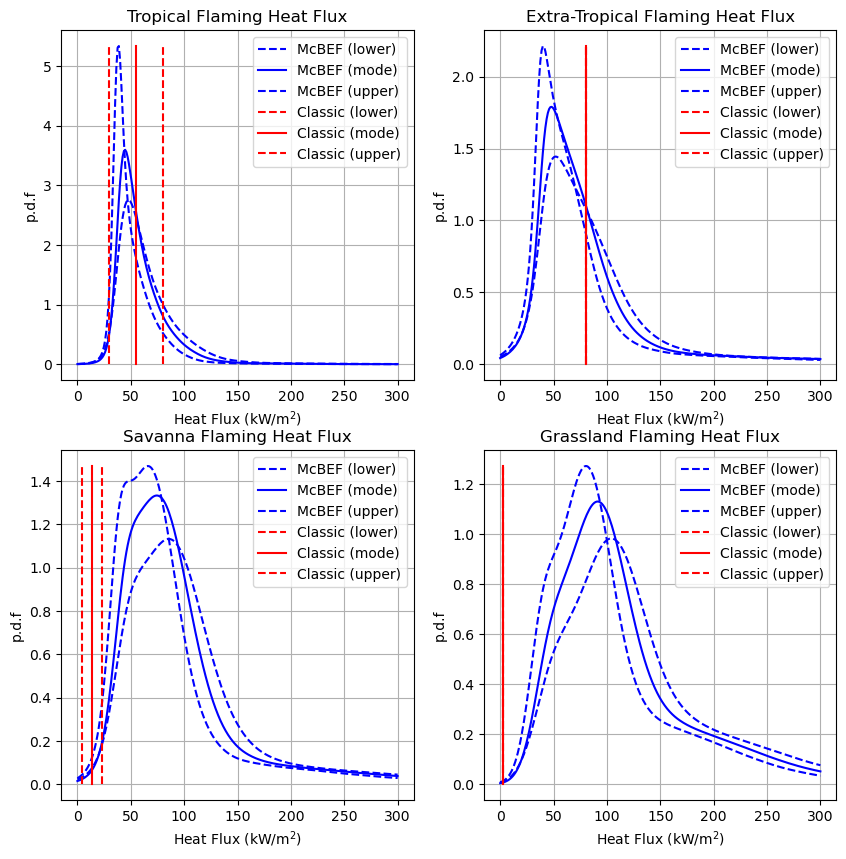

In [7]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plot_HF(bm.TROPICAL,bins_HF,fHEATFLUX_F[0],'Tropical Flaming Heat Flux', r'Heat Flux (kW/m$^2$)')
plt.subplot(222)
plot_HF(bm.EXTRA_TROPICAL,bins_HF,fHEATFLUX_F[1],'Extra-Tropical Flaming Heat Flux', r'Heat Flux (kW/m$^2$)')
plt.subplot(223)
plot_HF(bm.SAVANNA,bins_HF,fHEATFLUX_F[2],'Savanna Flaming Heat Flux', r'Heat Flux (kW/m$^2$)')
plt.subplot(224)
plot_HF(bm.GRASSLAND,bins_HF,fHEATFLUX_F[3],'Grassland Flaming Heat Flux', r'Heat Flux (kW/m$^2$)')

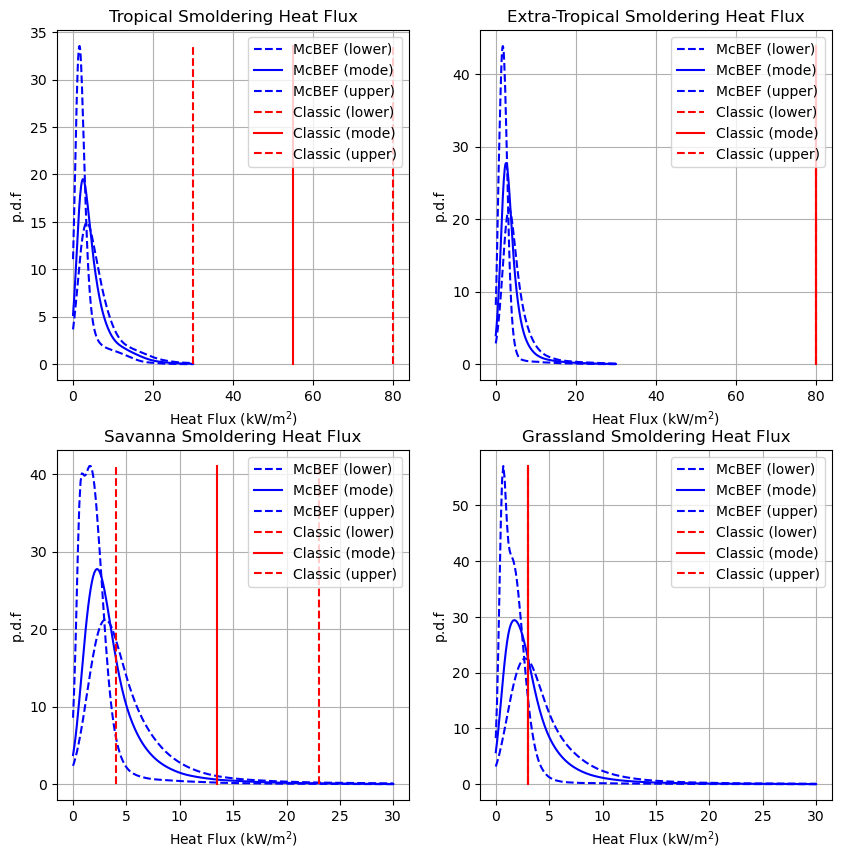

In [8]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plot_HF(bm.TROPICAL,bins_HS,fHEATFLUX_S[0],'Tropical Smoldering Heat Flux', r'Heat Flux (kW/m$^2$)')
plt.subplot(222)
plot_HF(bm.EXTRA_TROPICAL,bins_HS,fHEATFLUX_S[1],'Extra-Tropical Smoldering Heat Flux', r'Heat Flux (kW/m$^2$)')
plt.subplot(223)
plot_HF(bm.SAVANNA,bins_HS,fHEATFLUX_S[2],'Savanna Smoldering Heat Flux', r'Heat Flux (kW/m$^2$)')
plt.subplot(224)
plot_HF(bm.GRASSLAND,bins_HS,fHEATFLUX_S[3],'Grassland Smoldering Heat Flux', r'Heat Flux (kW/m$^2$)')

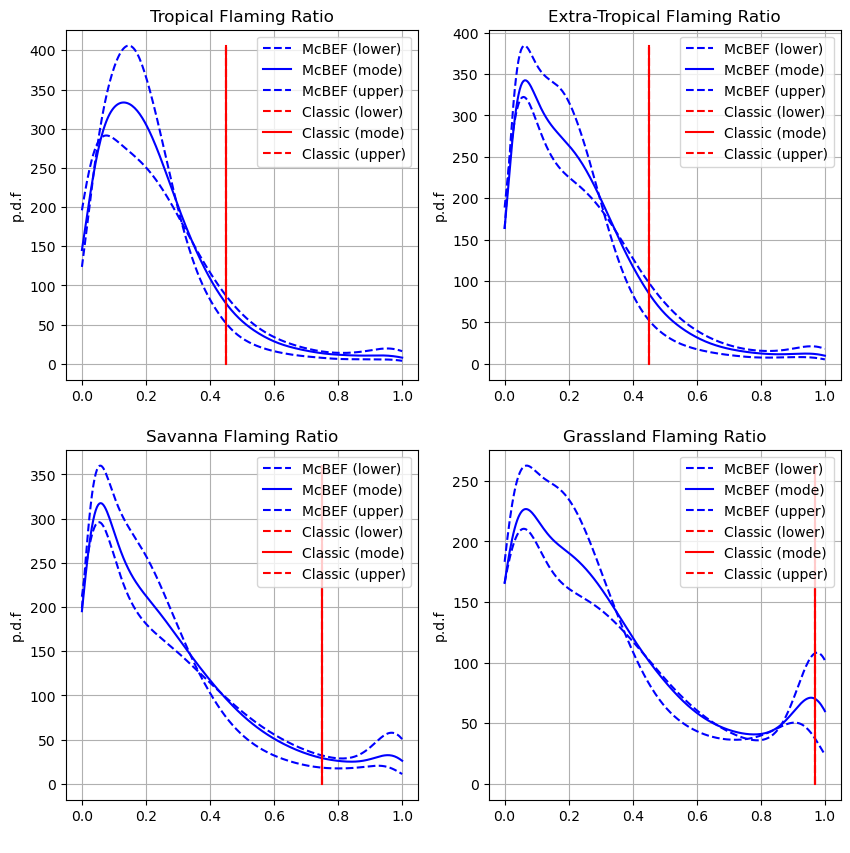

In [9]:
plt.figure(figsize=(10,10)) 
plt.subplot(221)
plot_HF(bm.TROPICAL,bins_R,fPOWER_R[0],'Tropical Flaming Ratio', r' ',Fraction=True)
plt.subplot(222)
plot_HF(bm.EXTRA_TROPICAL,bins_R,fPOWER_R[1],'Extra-Tropical Flaming Ratio', r' ',Fraction=True)
plt.subplot(223)
plot_HF(bm.SAVANNA,bins_R,fPOWER_R[2],'Savanna Flaming Ratio', r' ',Fraction=True)
plt.subplot(224)
plot_HF(bm.GRASSLAND,bins_R,fPOWER_R[3],'Grassland Flaming Ratio', r' ',Fraction=True)

## FRP and Areas

In [10]:
def plot_Prop(biome,bins,X,C,title,xlabel,range=None):

    plt.plot(bins,X[0],'b--',label='McBEF (lower)')
    plt.plot(bins,X[1],'b',  label='McBEF (mode)')
    plt.plot(bins,X[2],'b--',label='McBEF (upper)')
    
    if len(C.shape) == 2:                    
        plt.plot(bins,C[0],'r--',label='Classic (lower)')
        plt.plot(bins,C[1],'r',  label='Classic (mode)')
        plt.plot(bins,C[2],'r--',label='Classic (upper)')
    else:
        plt.plot(bins,C,'r',  label='Classic')                

    plt.grid(), plt.xlabel(xlabel),plt.ylabel('p.d.f'),plt.title(title)
    plt.legend(loc='upper right')
    
def plot_Prop2(bins,X,labX,Y,labY,Z,labZ,title,xlabel):

    plt.plot(bins,X,'b', label=labX)
    plt.plot(bins,Y,'r', label=labY)                 
    plt.plot(bins,Z,'g', label=labZ)
    
    plt.grid(), plt.xlabel(xlabel),plt.ylabel('p.d.f'),plt.title(title)
    plt.legend(loc='upper right')    


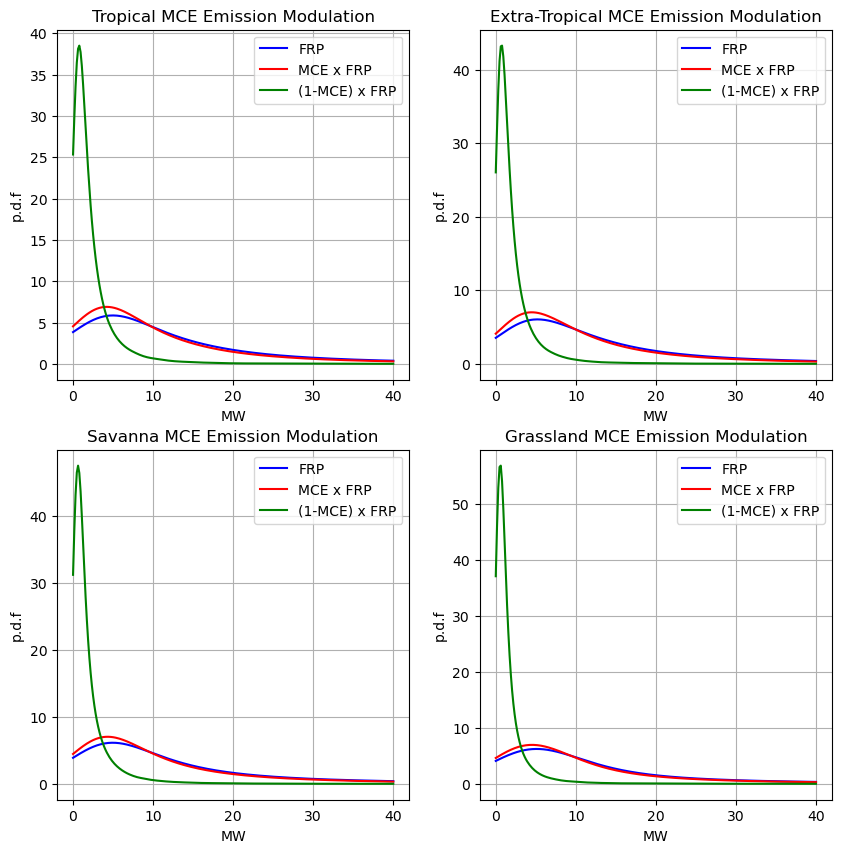

In [11]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop2(bins_M,fPOWER[0],'FRP',
                  fPOWER_M[0], 'MCE x FRP',
                  fPOWER_1mM[0], '(1-MCE) x FRP',
                  'Tropical MCE Emission Modulation', 'MW')
plt.subplot(222)
plot_Prop2(bins_M,fPOWER[1],'FRP',
                  fPOWER_M[1], 'MCE x FRP',
                  fPOWER_1mM[1], '(1-MCE) x FRP',
                  'Extra-Tropical MCE Emission Modulation', 'MW')
plt.subplot(223)
plot_Prop2(bins_M,fPOWER[2],'FRP',
                  fPOWER_M[2], 'MCE x FRP',
                  fPOWER_1mM[2], '(1-MCE) x FRP',
                  'Savanna MCE Emission Modulation', 'MW')
plt.subplot(224)
plot_Prop2(bins_M,fPOWER[3],'FRP',
                  fPOWER_M[3], 'MCE x FRP',
                  fPOWER_1mM[3], '(1-MCE) x FRP',
                  'Grassland MCE Emission Modulation', 'MW')

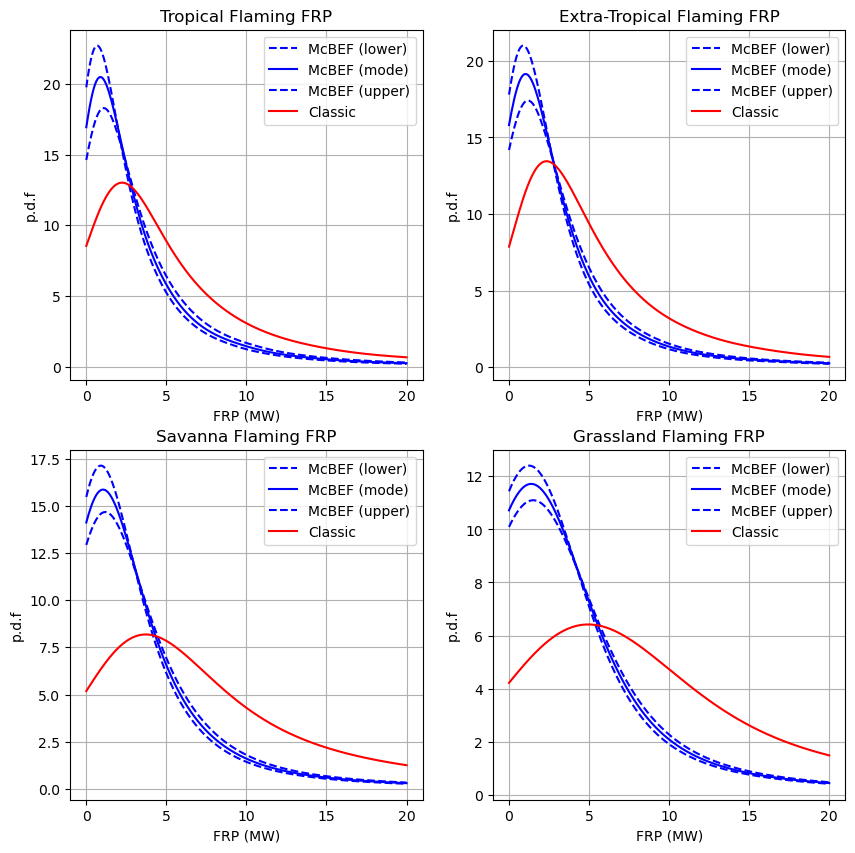

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop(bm.TROPICAL,bins_P,fPOWER_F[0],cPOWER_F[0],'Tropical Flaming FRP', 'FRP (MW)',range=(0,20))
plt.subplot(222)
plot_Prop(bm.EXTRA_TROPICAL,bins_P,fPOWER_F[1],cPOWER_F[1],'Extra-Tropical Flaming FRP', 'FRP (MW)',range=(0,20))
plt.subplot(223)
plot_Prop(bm.SAVANNA,bins_P,fPOWER_F[2],cPOWER_F[2],'Savanna Flaming FRP', 'FRP (MW)',range=(0,20))
plt.subplot(224)
plot_Prop(bm.GRASSLAND,bins_P,fPOWER_F[3],cPOWER_F[3],'Grassland Flaming FRP', 'FRP (MW)',range=(0,20))

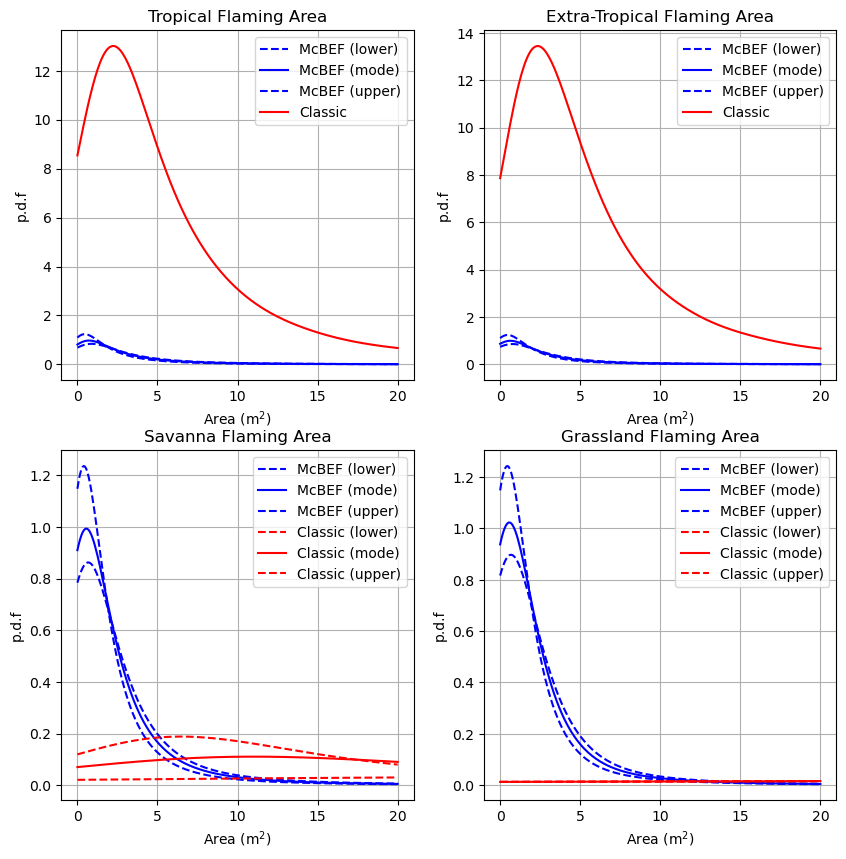

In [13]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plot_Prop(bm.TROPICAL,bins_P,fAREA_F[0],cPOWER_F[0],'Tropical Flaming Area', 'Area (m$^2$)',range=(0,500))
plt.subplot(222)
plot_Prop(bm.EXTRA_TROPICAL,bins_P,fAREA_F[1],cPOWER_F[1],'Extra-Tropical Flaming Area', 'Area (m$^2$)',range=(0,500))
plt.subplot(223)
plot_Prop(bm.SAVANNA,bins_P,fAREA_F[2],cAREA_F[2],'Savanna Flaming Area', 'Area (m$^2$)',range=(0,500))
plt.subplot(224)
plot_Prop(bm.GRASSLAND,bins_P,fAREA_F[3],cAREA_F[3],'Grassland Flaming Area', 'Area (m$^2$)',range=(0,500))